In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])
mpl.rcParams["font.size"] = "12"

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, plot_ode, plot_losses, l2
from modules.problems import LorenzSystem

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def train(
    problem,
    model,
    coef, num_iters, N_D, lr,
    collect_every=1000, print_every=1000
):
    collocation_points = torch.linspace(0, problem.T, N_D, requires_grad=True).reshape(-1, 1)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses, errors = [], []

    for i in range(num_iters + 1):

        optimizer.zero_grad()

        L_I = problem.loss_initial(model)
        L_X, L_Y, L_Z = problem.loss_physical(model, collocation_points)

        L = coef * L_I + (1 - coef) * (L_X + L_Y + L_Z)

        L.backward()
        optimizer.step()
        
        if i % collect_every == 0:
            preds = model(problem.t.reshape(-1, 1)).detach().numpy()
            x = preds[:,0].flatten()
            y = preds[:,1].flatten()
            z = preds[:,2].flatten()

            error_x = l2(x, problem.solution[0])
            error_y = l2(y, problem.solution[1])
            error_z = l2(z, problem.solution[2])

            losses.append(np.array([L_I.item(), L_X.item(), L_Y.item(), L_Z.item(), L.item()]))
            errors.append((error_x + error_y + error_z) / 3)
        
        if i % print_every == 0:
            print(f'Iteration {i} --- {(error_x + error_y + error_z) / 3}')
    
    return np.array(losses), np.array(errors)

In [ ]:
T = 1
s, p, b = 10, 28, 8/3
x_0, y_0, z_0 = 0, 1, 1.05
test_points = 1500
problem = LorenzSystem(T, (s, p, b), [x_0, y_0, z_0], test_points)

plot_ode(
    problem.t.numpy(), 
    [
        (problem.solution[0], r'$x(t)$', None), 
        (problem.solution[1], r'$y(t)$', None),
        (problem.solution[2], r'$z(t)$', None)
    ],
    size=(5, 3))

In [ ]:
L, W = 2, 64
model = FeedForwardNetwork(L, W, input_dim=1, output_dim=3)
model.init_weights(init.normal_)

coef = 0.5
num_iters = 2500
N_D = 1024*6
lr = 1e-3
collect_every = 250

losses, errors = train(
    problem,
    model,
    coef, num_iters, N_D, lr,
    collect_every=collect_every, print_every=500
)

In [ ]:
preds = model(problem.t.reshape(-1, 1)).detach().numpy()
x = preds[:,0].flatten()
y = preds[:,1].flatten()
z = preds[:,2].flatten()

plot_ode(
    problem.t.numpy(), 
    solutions=[
        (problem.solution[0], 'Solution', 'b'), 
        (problem.solution[1], None, 'b'),
        (problem.solution[2], None, 'b'),
        ],
    predicted=[
        (x, r'$\mathcal{N}(t)$', 'r'), 
        (y, None, 'r'),
        (z, None, 'r')
        ],
    title='Lorenz System', size=(5, 3)
)

In [ ]:
plot_losses(
    np.arange(0, num_iters+1, collect_every),
    losses=[
        (losses[:,0], r'$L_\mathcal{I}$'),
        (losses[:,1], r'$L_\mathcal{X}$'),
        (losses[:,2], r'$L_\mathcal{Y}$'),
        (losses[:,2], r'$L_\mathcal{Z}$'),
        (losses[:,3], r'$L_\mathcal{T}$')
    ],
    errors=[
        (errors[:,0], r'$\mathcal{X}(t)$'),
        (errors[:,1], r'$\mathcal{Y}(t)$'),
        (errors[:,2], r'$\mathcal{Z}(t)$')
    ]
)

## Interesting problem statements
---

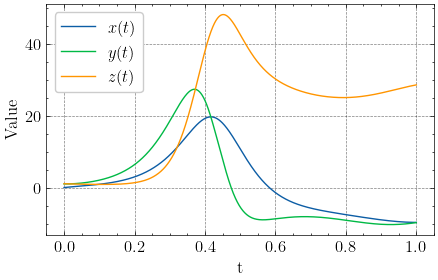

In [114]:
# Default

T = 1
s, p, b = 10, 28, 8/3
x_0, y_0, z_0 = 0, 1, 1.05
test_points = 1500
problem = LorenzSystem(T, (s, p, b), [x_0, y_0, z_0], test_points)

plot_ode(
    problem.t.numpy(), 
    [
        (problem.solution[0], r'$x(t)$', None), 
        (problem.solution[1], r'$y(t)$', None),
        (problem.solution[2], r'$z(t)$', None)
    ],
    size=(5, 3))

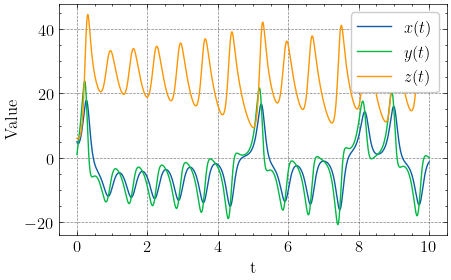

In [107]:
# Default parameters with large time and different initial values

T = 10
s, p, b = 10, 28, 8/3
x_0, y_0, z_0 = 5, 1, 6
test_points = 1500
problem = LorenzSystem(T, (s, p, b), [x_0, y_0, z_0], test_points)

plot_ode(
    problem.t.numpy(), 
    [
        (problem.solution[0], r'$x(t)$', None), 
        (problem.solution[1], r'$y(t)$', None),
        (problem.solution[2], r'$z(t)$', None)
    ],
    size=(5, 3))

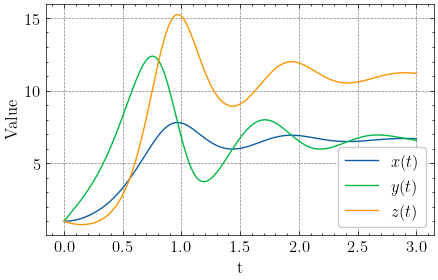

In [120]:
# Oscillator-like behavior

T = 3
s, p, b = 2, 12, 4
x_0, y_0, z_0 = 1, 1, 1
test_points = 1500
problem = LorenzSystem(T, (s, p, b), [x_0, y_0, z_0], test_points)

plot_ode(
    problem.t.numpy(), 
    [
        (problem.solution[0], r'$x(t)$', None), 
        (problem.solution[1], r'$y(t)$', None),
        (problem.solution[2], r'$z(t)$', None)
    ],
    size=(5, 3))

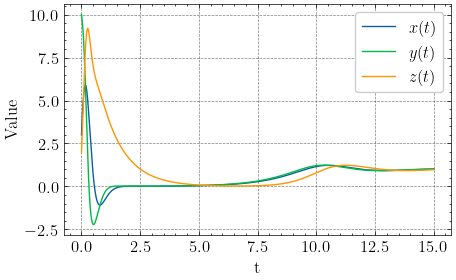

In [125]:
# Unusual behavior

T = 15
s, p, b = 5, 2, 1
x_0, y_0, z_0 = 3, 10, 2
test_points = 1500
problem = LorenzSystem(T, (s, p, b), [x_0, y_0, z_0], test_points)

plot_ode(
    problem.t.numpy(), 
    [
        (problem.solution[0], r'$x(t)$', None), 
        (problem.solution[1], r'$y(t)$', None),
        (problem.solution[2], r'$z(t)$', None)
    ],
    size=(5, 3))

In [2]:
def get_problem(N):
    match N:
        case 1:
            T = 1
            s, p, b = 10, 28, 8/3
            x_0, y_0, z_0 = 0, 1, 1.05
            test_points = 1500
            
        case 2:
            T = 10
            s, p, b = 10, 28, 8/3
            x_0, y_0, z_0 = 5, 1, 6
            test_points = 1500
            
        case 3:
            T = 3
            s, p, b = 2, 12, 4
            x_0, y_0, z_0 = 1, 1, 1
            test_points = 1500
            
        case 4:
            T = 15
            s, p, b = 5, 2, 1
            x_0, y_0, z_0 = 3, 10, 2
            test_points = 1500
    
    problem = LorenzSystem(T, (s, p, b), [x_0, y_0, z_0], test_points)
    
    return problem

In [7]:
import optuna

best_model = None
model = None

def objective(trial):
    
    global model
    
    L = trial.suggest_int('L', 2, 8, step=2)
    W = trial.suggest_int('W', 32, 128, step=32)
    model = FeedForwardNetwork(L, W, input_dim=1, output_dim=3).to(device)
    init_rule = trial.suggest_categorical(
        'initialization', 
        ['default', 'eye', 'zeros', 'ones', 'normal', 'xavier', 'kaiming', 'orthogonal']
    )
    if init_rule == 'eye':
        model.init_weights(init.eye_)
    elif init_rule == 'zeros': 
        model.init_weights(init.zeros_)
    elif init_rule == 'ones': 
        model.init_weights(init.ones_)
    elif init_rule == 'normal': 
        model.init_weights(init.normal_)
    elif init_rule == 'xavier':
        model.init_weights(init.xavier_normal_)
    elif init_rule == 'kaiming':
        model.init_weights(init.kaiming_normal_)
    elif init_rule == 'orthogonal':
        model.init_weights(init.orthogonal_)
    
    N_D = trial.suggest_int('N_D', 512, 1024 * 10, step=512)
    lr = trial.suggest_float('lr', 1e-5, 1.0, log=True)
    
    coef = trial.suggest_float('coef', 0.05, 0.95)
    
    sampling = trial.suggest_categorical('sampling', ['random', 'grid'])
    
    if sampling == 'random':
        collocation_points = torch.tensor(np.random.uniform(0, problem.T, N_D), dtype=torch. float32, requires_grad=True).reshape(-1, 1).to(device)
    else:
        collocation_points = torch.linspace(0, problem.T, N_D, requires_grad=True).reshape(-1, 1).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for i in range(15000):

        optimizer.zero_grad()

        L_I = problem.loss_initial(model)
        L_X, L_Y, L_Z = problem.loss_physical(model, collocation_points)

        L = coef * L_I + (1 - coef) * (L_X + L_Y + L_Z)

        L.backward()
        optimizer.step()
        
        if (i + 1) % 1000 == 0:
            preds = model(problem.t.reshape(-1, 1)).detach().cpu().numpy()
            x = preds[:,0].flatten()
            y = preds[:,1].flatten()
            z = preds[:,2].flatten()

            error_x = l2(x, problem.solution[0])
            error_y = l2(y, problem.solution[1])
            error_z = l2(z, problem.solution[2])
            
            error = (error_x + error_y + error_z) / 3
            
            trial.report(error, i + 1)
            
            if trial.should_prune():
                raise optuna.TrialPruned()
            
    return error

def callback(study, trial):
    global best_model
    
    if study.best_trial == trial:
        best_model = model

In [ ]:
for problem_number in range(1, 5):
    problem = get_problem(problem_number)

    study = optuna.create_study(
        study_name=f'lz_{problem_number}',
        direction='minimize', 
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(max_resource=15000)
        )

    study.optimize(objective, n_trials=50, callbacks=[callback])
    study.trials_dataframe().to_csv(f'./studies/{study.study_name}.csv', sep=',')
        
    torch.save(best_model, f'./studies/{study.study_name}_best_model.pt')

In [ ]:
test_model = torch.load(f'./studies/lv_1_best_model.pt', map_location='cpu')

preds = test_model(problem.t.reshape(-1, 1)).detach().numpy()
x, y = preds[:,0].flatten(), preds[:,1].flatten()

plot_ode(
    problem.t.numpy(), 
    solutions=[(problem.solution[0], r'$x(t)$', None), (problem.solution[1], r'$y(t)$', None)],
    predicted=[(x, r'$\mathcal{X}(t)$', None), (y, r'$\mathcal{Y}(t)$', None)],
    title='Lotka-Volterra System', size=(5, 3)
)